In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Function for full wave rectification
def full_wave_rectification(emg_data):
    return np.abs(emg_data)

# Function to design a Butterworth filter
def butter_filter(cutoff_freq, sampling_freq, btype, order=4):
    nyquist_freq = 0.5 * sampling_freq
    if isinstance(cutoff_freq, list) or isinstance(cutoff_freq, tuple):
        normal_cutoff = [freq / nyquist_freq for freq in cutoff_freq]
    else:
        normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

# Function to apply a Butterworth filter to EMG signals
def butter_filter_signal(emg_data, cutoff_freq, sampling_freq, btype='band', order=4):
    emg_data_filtered = np.zeros_like(emg_data)
    for ch in range(emg_data.shape[0]):
        b, a = butter_filter(cutoff_freq, sampling_freq, btype, order)
        emg_data_filtered[ch, :] = filtfilt(b, a, emg_data[ch, :])
    return emg_data_filtered

# Function for RMS smoothing
def rms_smoothing(emg_data, window_size):
    smoothed = np.zeros_like(emg_data)
    half_win = window_size // 2
    for ch in range(emg_data.shape[0]):
        for t in range(half_win, emg_data.shape[1] - half_win):
            window = emg_data[ch, t - half_win:t + half_win]
            smoothed[ch, t] = np.sqrt(np.mean(window ** 2))
    return smoothed

# Function to plot EMG signals
def plot_emg_data(emg_data, sampling_freq, title="EMG Signal", duration_sec=None):
    if duration_sec:
        n_samples = int(duration_sec * sampling_freq)
        emg_data = emg_data[:, :n_samples]
    
    time_axis = np.arange(emg_data.shape[1]) / sampling_freq
    plt.figure(figsize=(12, 8))
    for ch in range(min(8, emg_data.shape[0])):  # Plot up to 8 channels
        plt.plot(time_axis, emg_data[ch, :], label=f"Channel {ch+1}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to preprocess EMG
def preprocess_emg(X_raw, sampling_freq=1024):
    X_processed = np.zeros_like(X_raw)
    for session in range(X_raw.shape[0]):
        emg = X_raw[session]

        # Step 1: Full-wave rectification
        emg_rectified = full_wave_rectification(emg)

        # Step 2: Bandpass filter (e.g., 20-450 Hz typical for EMG)
        emg_filtered = butter_filter_signal(emg_rectified, [20, 450], sampling_freq, btype='band', order=4)

        # Step 3: RMS smoothing with a 100ms window
        window_size_samples = int(0.1 * sampling_freq)  # 100ms window
        emg_smoothed = rms_smoothing(emg_filtered, window_size_samples)

        X_processed[session] = emg_smoothed

    return X_processed

Original EMG shape: (5, 8, 230000)


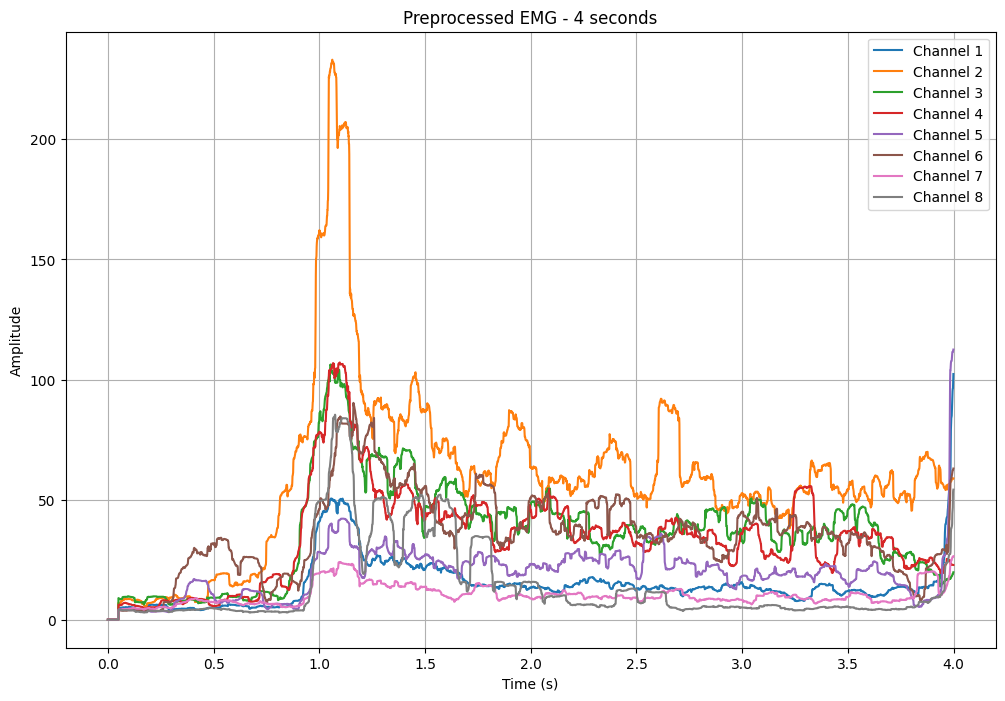

In [ ]:
# Example assuming X_train_raw already loaded
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project'
X_train_raw = np.load(PATH + '/data/guided/guided_dataset_X.npy')

print(f"Original EMG shape: {X_train_raw.shape}")  # (5 sessions, 8 channels, 230000 samples)

# Preprocess EMG
X_train_processed = preprocess_emg(X_train_raw, sampling_freq=1024)

# Plot only first 4 seconds of session 1
plot_emg_data(X_train_processed[0], sampling_freq=1024, title="Preprocessed EMG - 4 seconds", duration_sec=50)

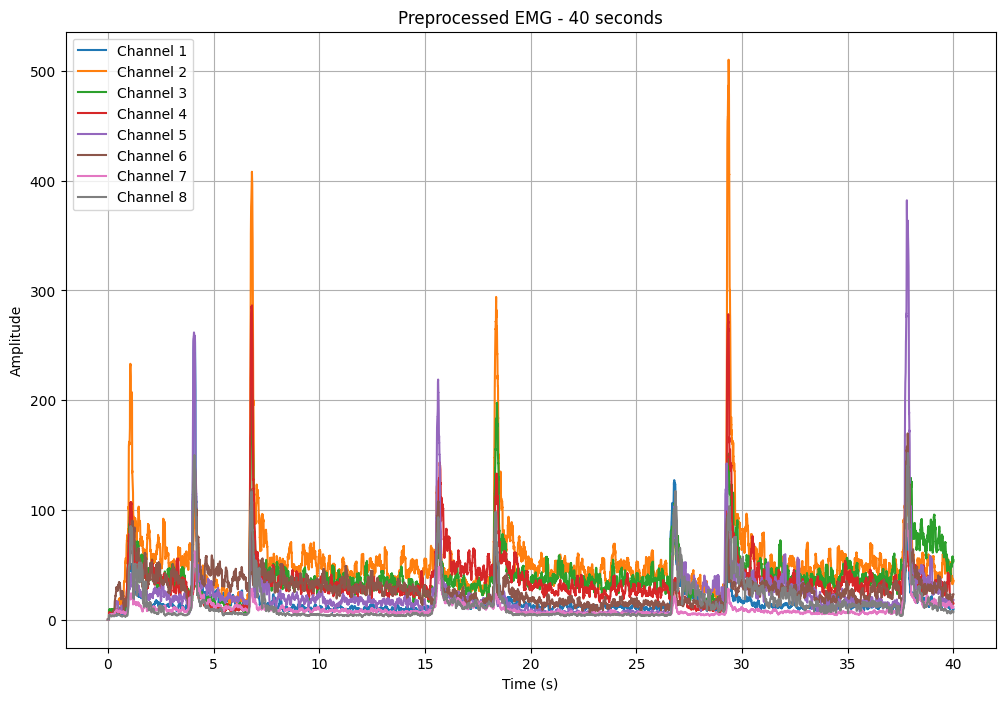

In [ ]:
# Plot only first 40 seconds of session 1
plot_emg_data(X_train_processed[0], sampling_freq=1024, title="Preprocessed EMG - 40 seconds", duration_sec=40)